<a href="https://colab.research.google.com/github/juergenlandauer/FoundationModelsArchaeology/blob/main/Experiment_4_Hillforts_SAM_segmentation/SAM_hillforts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic site segmentation with SAM: English hillforts
Author: Juergen Landauer (juergen AT landauer-ai.de)

To start, first go to the "Input parameters" section below and review or (optionally) adjust parameters. Then run the entire Notebook by choosing Runtime->Run all in the menu above.

### Install SAM2 and dependencies

We first install Meta's SAM, Roboflow's Supervision and other libraries, then the SAM model weights. This could take up to 5 minutes.

In [1]:
!pip install -Uq opencv-python supervision
!pip install -Uq 'git+https://github.com/facebookresearch/sam2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Caution!
You might get asked to restart this session here. This is mandatory.

# Input parameters

Review all parameters in this section and (optionally) adjust them on the right side. For example, you can upload your own input zip file by providing an URL.

In [48]:
# feel free to replace this with your own imagery by providing a download URL (e.g. from Google Drive)
# Note that the ZIP file must contain only images in its root folder. No sub-directories!

INPUT_ZIP_URL = 'https://www.dropbox.com/scl/fi/nw5f5oi2f6a1lmmaatgqx/DEM_forts_EN_768_V8_hillshade.zip?rlkey=uti549njlwi2unlyo1y1wdlol&st=v1l2s2ho&dl=0' # @param {"allow-input":true}

## Setup

In [49]:
# download data
!rm -rf input output file.zip
!mkdir -p input/
!wget -O file.zip "$INPUT_ZIP_URL"
!unzip -q file.zip -d input

--2025-07-23 08:16:32--  https://www.dropbox.com/scl/fi/nw5f5oi2f6a1lmmaatgqx/DEM_forts_EN_768_V8_hillshade.zip?rlkey=uti549njlwi2unlyo1y1wdlol&st=v1l2s2ho&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8fd779f43127bee3ee559d9929.dl.dropboxusercontent.com/cd/0/inline/CuCx-JmzrEnXcmQpdPBaWHpjN6PPfw_fD8dqC1QZA6hUiU9ksXXBY88-NDxmOomWC9Fga6nYSluMfeEABgs2xUToDuKO4K2LnF-0vylc4lLfsZ-p42fO9pnxA5xexXba3jc/file# [following]
--2025-07-23 08:16:33--  https://uc8fd779f43127bee3ee559d9929.dl.dropboxusercontent.com/cd/0/inline/CuCx-JmzrEnXcmQpdPBaWHpjN6PPfw_fD8dqC1QZA6hUiU9ksXXBY88-NDxmOomWC9Fga6nYSluMfeEABgs2xUToDuKO4K2LnF-0vylc4lLfsZ-p42fO9pnxA5xexXba3jc/file
Resolving uc8fd779f43127bee3ee559d9929.dl.dropboxusercontent.com (uc8fd779f43127bee3ee559d9929.dl.dropboxusercontent.com)... 162.125.2.15, 2620:10

In [50]:
# download SAM weights
!mkdir -p ../checkpoints/
#!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt

--2025-07-23 08:16:45--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.15, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.1_hiera_small.pt.3’

sam2.1_hiera_small. 100%[===================>] 175.87M  52.2MB/s    in 3.3s    

2025-07-23 08:16:49 (54.1 MB/s) - ‘../checkpoints/sam2.1_hiera_small.pt.3’ saved [184416285/184416285]



In [51]:
from glob import glob
from pathlib import Path
from tqdm import tqdm
import albumentations as A
import os

### Imports

In [52]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [53]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model





In [54]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [55]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = "../checkpoints/sam2.1_hiera_small.pt"
CONFIG = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

## Automated mask generation

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [56]:
mask_generator = SAM2AutomaticMaskGenerator(
    sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

**NOTE:** OpenCV loads images in BGR format by default, so we convert to RGB for compatibility with the mask generator.

In [57]:
def generate (image):
    image_rgb = image

    sam2_result = mask_generator.generate(image_rgb)
    return sam2_result

### Output format

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation

In [58]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

def annotate(image_bgr, sam2_result, filename):
    detections = sv.Detections.from_sam(sam_result=sam2_result)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )

    if filename is not None:
        cv2.imwrite(filename, annotated_image)

In [70]:
def read_img(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [60]:
def preprocessSnippetNONE(image: np.ndarray): return image

In [61]:
myfilter = preprocessSnippetNONE

## process folder

In [62]:
IMAGE_PATH = "./input/"

In [63]:
OUTPATH = Path("./output")
os.makedirs(OUTPATH, exist_ok=True)

files = sorted(glob(IMAGE_PATH+"**/*.*", recursive=True))
#files = files[:2] # for testing
len(files)

1136

In [64]:
sz = 768
default_box = [
    {'x': sz//2, 'y': sz//2, 'width': 0, 'height': 0, 'label': ''},
]

input_point = np.array([
    [sz//2, sz//2]
])
input_label = np.ones(input_point.shape[0])
input_label

array([1.])

In [65]:
predictor = SAM2ImagePredictor(sam2_model)

  0%|          | 0/1136 [00:00<?, ?it/s]

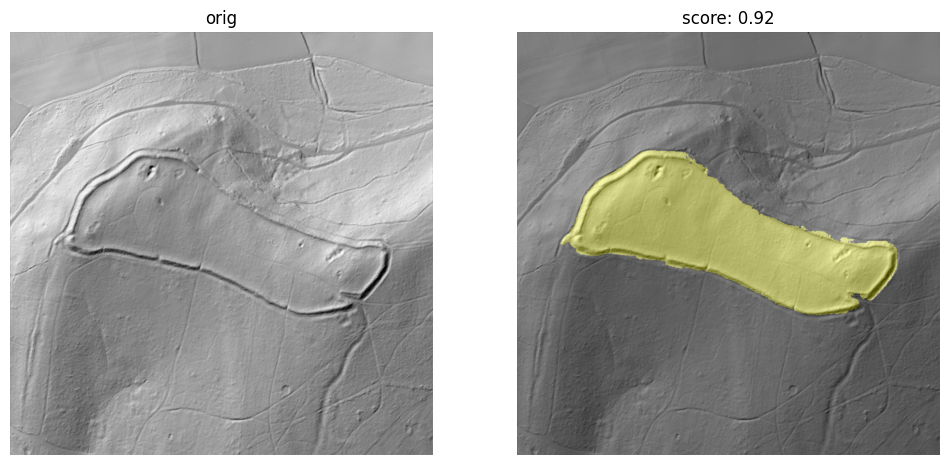

  0%|          | 1/1136 [00:00<12:49,  1.48it/s]

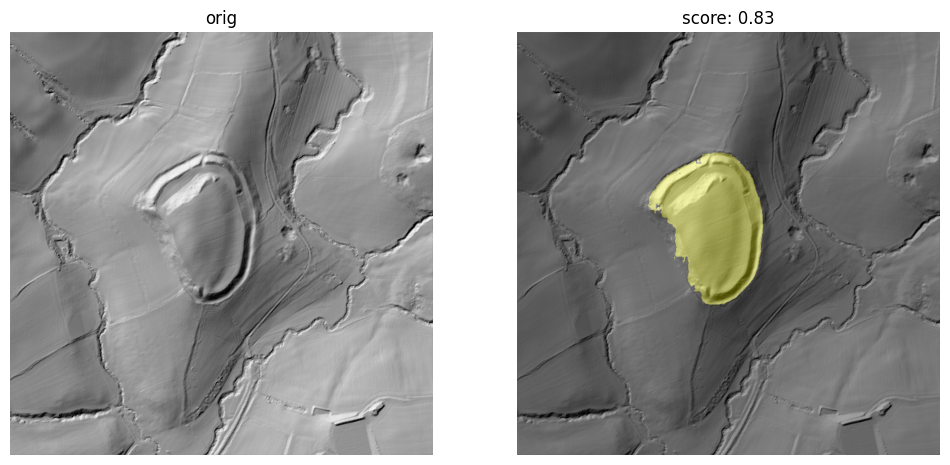

  0%|          | 2/1136 [00:01<11:47,  1.60it/s]

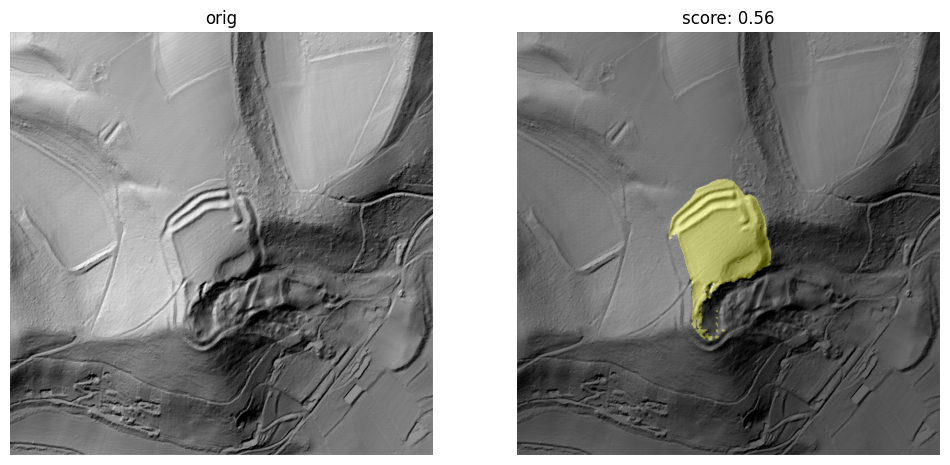

  0%|          | 3/1136 [00:01<11:34,  1.63it/s]

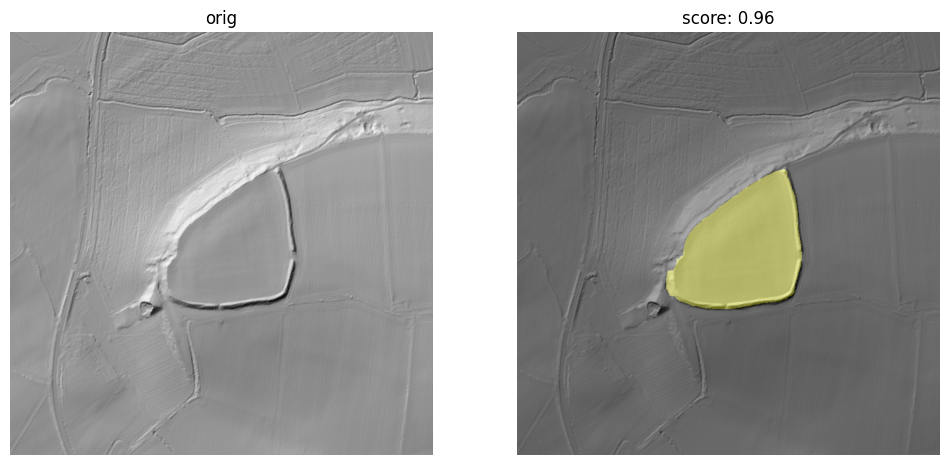

  0%|          | 4/1136 [00:02<11:22,  1.66it/s]

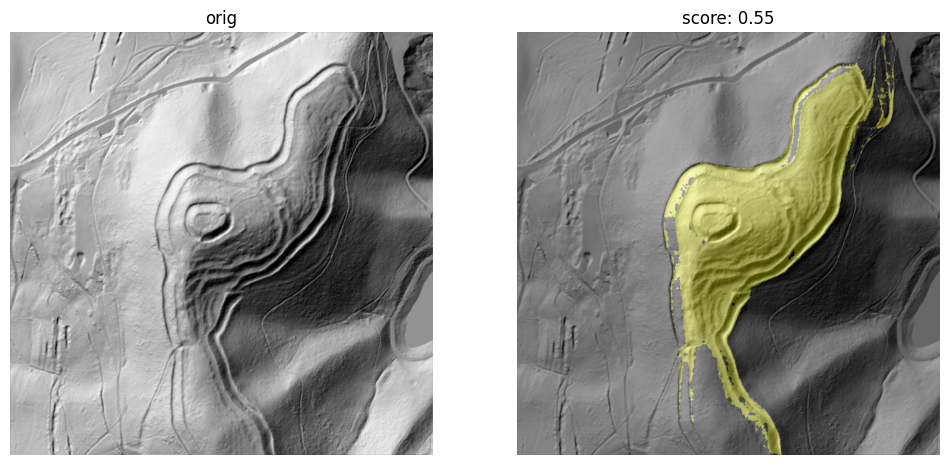

  0%|          | 5/1136 [00:03<13:33,  1.39it/s]

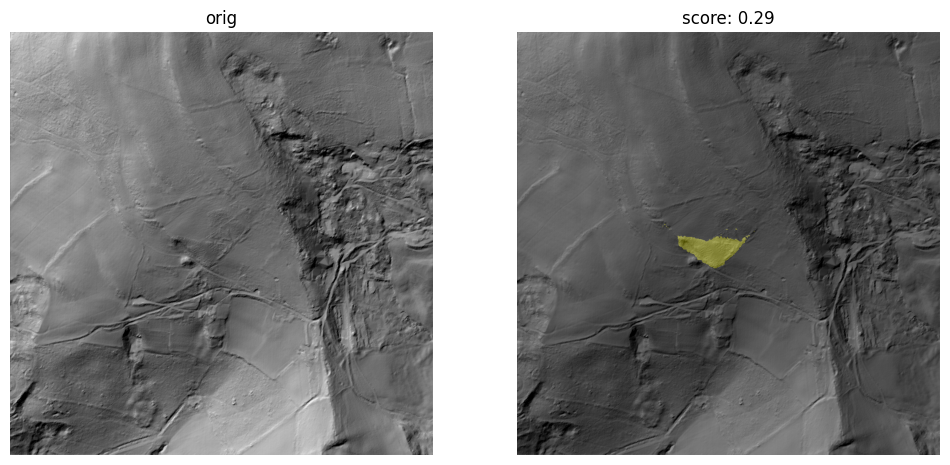

  1%|          | 6/1136 [00:03<12:52,  1.46it/s]

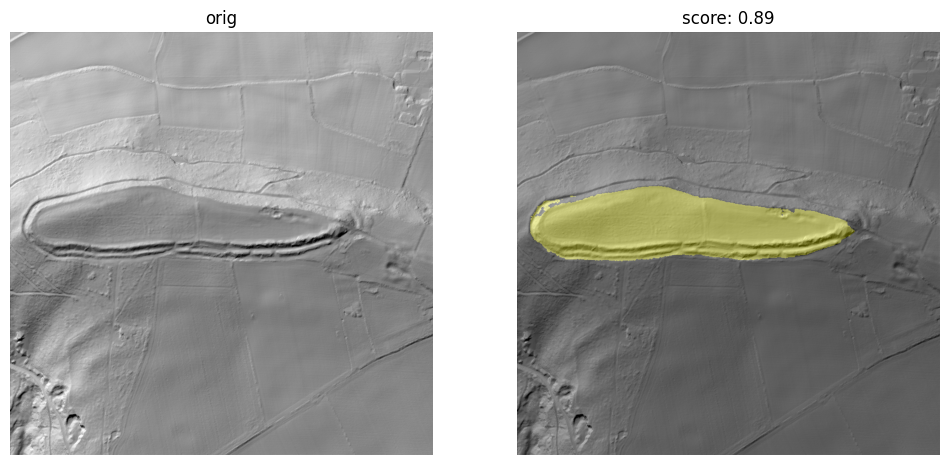

  1%|          | 7/1136 [00:04<12:20,  1.52it/s]

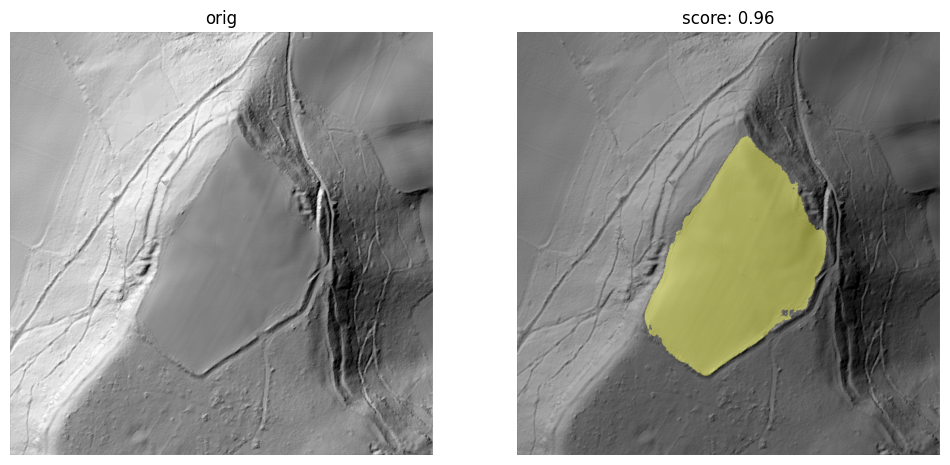

  1%|          | 8/1136 [00:05<12:05,  1.56it/s]

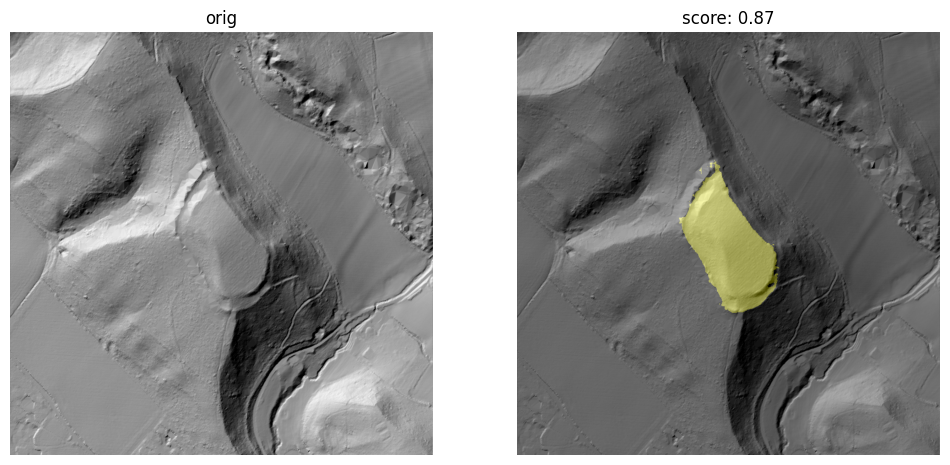

  1%|          | 9/1136 [00:05<11:49,  1.59it/s]

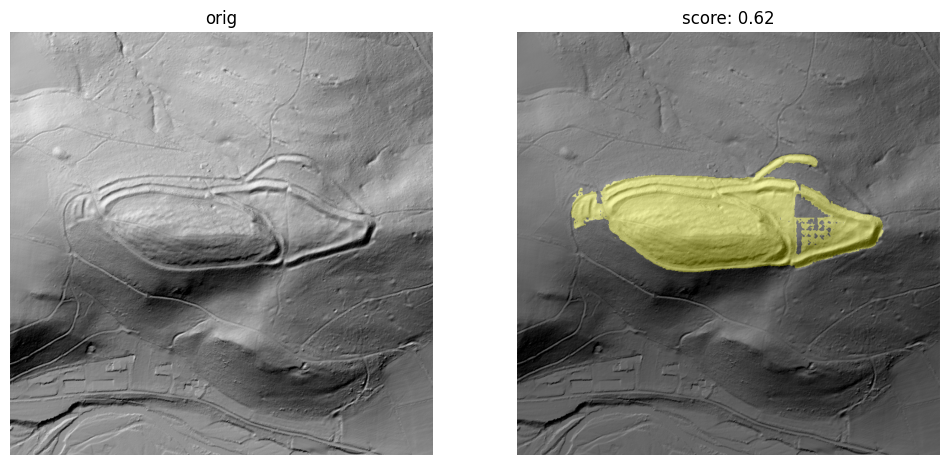

  1%|          | 10/1136 [00:07<13:18,  1.41it/s]


KeyboardInterrupt: 

In [72]:
for f in tqdm(files):
    p = Path(f)
    image_rgb = read_img(p)
    image_rgb2 = image_rgb

    predictor.set_image(image_rgb)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    for s in range(len(scores)):
        if scores[s] == max(scores): # got it
            mask = masks[s].astype(np.uint8)
            break

    redImg = np.zeros_like(image_rgb2)
    redImg[:,:] = (0, 255, 255)
    redMask = cv2.bitwise_and(redImg, redImg, mask=mask)

    overlay = cv2.addWeighted(redMask, .3, image_rgb2, 1-.3, 0)

    sv.plot_images_grid(
        images=[image_rgb, overlay],
        titles=["orig", f"score: {scores[s]:.2f}"],
        grid_size=(1, 2),
        size=(12, 6)
    )
    # save mask and overlay
    cv2.imwrite(OUTPATH/("orig_"+p.name), image_rgb2)
    cv2.imwrite(OUTPATH/("SAM_"+p.name), overlay)

## Export results for download
We now open a file download dialog for the output.zip. Simply store the output in your local computer. Done :-)

In [69]:
!zip -r output.zip output
from google.colab import files as colabfiles
colabfiles.download('output.zip')

updating: output/ (stored 0%)
updating: output/orig_EN0011_0.0_768_768.tif (deflated 1%)
updating: output/SAM_EN0009_0.0_768_768.tif (deflated 0%)
updating: output/orig_EN0004_0.0_768_768.tif (deflated 0%)
updating: output/SAM_EN0007_0.0_768_768.tif (deflated 0%)
updating: output/orig_EN0005_0.0_768_768.tif (deflated 1%)
updating: output/SAM_EN0013_0.0_768_768.tif (deflated 0%)
updating: output/SAM_EN0003_0.0_768_768.tif (deflated 0%)
updating: output/SAM_EN0004_0.0_768_768.tif (deflated 0%)
updating: output/SAM_EN0002_0.0_768_768.tif (deflated 0%)
updating: output/orig_EN0016_0.0_768_768.tif (deflated 0%)
updating: output/SAM_EN0012_0.0_768_768.tif (deflated 0%)
updating: output/SAM_EN0015_0.0_768_768.tif (deflated 0%)
updating: output/orig_EN0009_0.0_768_768.tif (deflated 0%)
updating: output/SAM_EN0011_0.0_768_768.tif (deflated 1%)
updating: output/orig_EN0008_0.0_768_768.tif (deflated 0%)
updating: output/SAM_EN0008_0.0_768_768.tif (deflated 0%)
updating: output/orig_EN0014_0.0_768

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>